In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from abc import ABC, abstractmethod
from rl import get_bandit_envs, run_bandit
from rl import PosteriorHallucinationAlg, NeuralLinearAlg, BetaBernoulliAlg, UCBAlg
from run_bandit_psar import load_bandit_rewards, get_article_ordering
from train_fns import get_model_and_optimizer_MIND as get_model_and_optimizer

## Path Info

In [2]:
# needs to  match loaded
seed=23485223

# which data split to use
rl_dataset = 'val'

In [3]:
path_base = "/shared/share_mala/implicitbayes/dataset_files/MIND_data/filter100"
BERT_marginal_run_dir = path_base + "/bertmodels/marg_bert_rate/marginal:epochs=500,bs=100,lr=1e-05,bert_lr=1e-05,wd=0.01,sample_frac=1.0,onelayer=False,freezebert=False,has_marg_model=False,min_obs_length=100,no_Z=False,transform_success_p_alpha=1,num_train_rows_for_eval=None,seed=2340923"

model_paths = {
    'BERT_marg_100': '/shared/share_mala/implicitbayes/dataset_files/MIND_data/filter100/models/0327_bert_marginal_split_v2/marginal:epochs=500,bs=100,lr=1e-05,wd=0.01,MLP_layers=3,MLP_width=100,weight_factor=1,max_obs=500,repeat_suffstat=1,datasplit=first_100,bert_lr=1e-05,sample_frac=1.0,p_alpha=1,seed=2340923',
    'BERT bb joint ab': '/shared/share_mala/implicitbayes/dataset_files/MIND_data/filter100/models/seq_bb_sweep_relu/sequential:epochs=500,bs=100,lr=1e-05,wd=0.01,MLP_layers=3,MLP_width=100,weight_factor=1,max_obs=500,repeat_suffstat=100,bert_lr=1e-08,sample_frac=1.0,p_alpha=1,sched=constant,BB=True,seed=2340923',
    'BERT joint': '/shared/share_mala/implicitbayes/dataset_files/MIND_data/filter100/models/seq_bert_rerun/sequential:epochs=500,bs=100,lr=1e-05,wd=0.01,MLP_layers=3,MLP_width=100,weight_factor=1,max_obs=500,repeat_suffstat=100,bert_lr=1e-08,sample_frac=1.0,p_alpha=1,seed=2340923', 
    'category joint': '/shared/share_mala/implicitbayes/dataset_files/MIND_data/filter100/models/0404_MIND_category2/sequential:epochs=1000,bs=100,lr=0.001,wd=0.01,MLP_layers=3,MLP_width=50,weight_factor=1,max_obs=500,repeat_suffstat=10,category=1,sample_frac=1.0,p_alpha=1,sched=constant,seed=2340923'
}

# Load predictions, models, etc

In [4]:
# LOAD MODEL PREDICTIONS ===========================================
prediction_dicts = {}
for name, run_dir in model_paths.items():
    try:
        preds = torch.load(run_dir + '/best_loss_predictions.pt')
        prediction_dicts[name] = preds
    except:
        print(f'preds: skip {name}')
    
# LOAD MODEL CHECKPOINTS ===========================================
all_model_checkpoints = {}
for model_name, model_dir in model_paths.items():
    model_path = model_dir + "/best_loss.pt"
    model_dict = torch.load(model_path, map_location=torch.device('cpu'))
    all_model_checkpoints[model_name] = model_dict
    
# LOAD MODEL EMBEDDINGS ===========================================
model_embeds = {}
for model_name, model_dir in model_paths.items():
    try:
        model_path = model_dir + "/best_loss_row_embeds.pt"
        model_dict = torch.load(model_path, map_location=torch.device('cpu'))
        model_embeds[model_name] = model_dict
    except:
        print(f'embeds: skip {name}')

In [5]:
from closed_form_models import BetaBernoulli

# Set up bandit env

In [6]:
val_batch_size = len(prediction_dicts['BERT joint'][rl_dataset]['click_rates'])
article_ordering = get_article_ordering(seed, val_batch_size)

In [7]:
# Get click rates for arms in val set ===============================================
success_p_all = None
for model_name, model_dict in all_model_checkpoints.items():
    if "marg" in model_name:
        continue

    # CHECK MATCH TO ENVIRONEMENT ARMS -------------------------------------
    model_saved_p_raw = model_dict[f'{rl_dataset}_loss_dict']['click_rates'].numpy()
    model_shuffled_p = model_saved_p_raw[article_ordering]
    
    if success_p_all is None:
        success_p_all = model_shuffled_p
    else:
        assert np.all( np.equal(success_p_all, model_shuffled_p) )

In [10]:
# Make bandit environments ------------------------------------
num_bandit_envs = 500
T = 2000
num_arms = 10
all_bandit_envs = get_bandit_envs(num_arms, T, num_bandit_envs, success_p_all, seed=seed)
num_imagined = 500
bandit_run_results = {}

# Load bandit algs

**Sequential (BERT)**

In [11]:
saved_model_names = ['BERT joint', 'BERT bb joint ab', 'category joint']

In [12]:
num_imagined = 500
for model_name in saved_model_names:
    bandit_dir = model_paths[model_name] + f'/bandit/num_arms={num_arms},T={T},num_imagined={num_imagined},seed={seed},dataset={rl_dataset},alg=sequential/'
    bandit_rewards = load_bandit_rewards(bandit_dir, all_bandit_envs, success_p_all)
    bandit_run_results[f'{model_name} im={num_imagined}'] = bandit_rewards['rewards']

In [13]:
bandit_dir = model_paths['BERT joint'] + f'/bandit/num_arms={num_arms},T={T},num_imagined={num_imagined},seed={seed},dataset={rl_dataset},alg=sequential/'
bandit_rewards_joint = load_bandit_rewards(bandit_dir, all_bandit_envs, success_p_all)

In [14]:
for gamma0 in [10.0,50.0,100.0,400.0]:
    for rho in [0.25,0.5]:
        try:
            bandit_dir = model_paths['BERT joint'] + f'/bandit/num_arms={num_arms},T={T},seed={seed},dataset={rl_dataset},alg=squarecb,gamma0={gamma0},rho={rho}'
            bandit_rewards = load_bandit_rewards(bandit_dir, all_bandit_envs, success_p_all)
            bandit_run_results[f'BERT squarecb {gamma0} {rho}'] = bandit_rewards['rewards']
        except:
            print(gamma0, rho)

# Make bandit algs

**Oracle**

In [16]:
# REWARD UNDER ORACLE BANDIT ALGORITHM ========================================================
all_max_rewards = []
all_cum_rewards = []
for bandit_env, chosen_arms in all_bandit_envs:
    max_reward = np.max(bandit_env.success_p)
    assert np.all( np.equal( bandit_env.success_p, success_p_all[chosen_arms] ) )
    all_max_rewards.append( np.ones(T)*max_reward )
    all_cum_rewards.append( np.cumsum( np.ones(T)*max_reward ) )
bandit_run_results['oracle'] = np.concatenate([np.expand_dims(x,1) for x in all_max_rewards],1).T

**Beta-binomial with flat prior**

In [17]:
name = 'BB flat prior'
all_rewards = []
for bandit_env, chosen_arms in tqdm(all_bandit_envs):
    # Instantiate bandit algorithm ------------------------------------
    bandit_alg = BetaBernoulliAlg(len(chosen_arms), {'alpha':1,'beta':1})

    reward_dict = run_bandit(bandit_env, bandit_alg, T)
    all_rewards.append(reward_dict['expected_rewards'])

rewards_array = np.array(all_rewards)
bandit_run_results[name] = rewards_array

  0%|          | 0/500 [00:00<?, ?it/s]

**UCB**

In [19]:
bandit_run_results['oracle']
all_rewards = []
for bandit_env, chosen_arms in tqdm(all_bandit_envs):
    
    # Instantiate bandit algorithm ------------------------------------
    bandit_alg = UCBAlg(num_arms=num_arms)

    reward_dict = run_bandit(bandit_env, bandit_alg, T)
    all_rewards.append(reward_dict['expected_rewards'])

rewards_array = np.array(all_rewards)
bandit_run_results['UCB'] = rewards_array

  0%|          | 0/500 [00:00<?, ?it/s]

**Neural Linear**

In [20]:
params = {
    's_squared':0.25,
    'sigma_squared':1,
}
all_rewards = []
pred_means = prediction_dicts['BERT_marg_100'][rl_dataset]['theta_hats'][:,0]
for bandit_env, chosen_arms in tqdm(all_bandit_envs):
    # Instantiate bandit algorithm ------------------------------------
    bandit_alg = NeuralLinearAlg(pred_means[article_ordering][chosen_arms], num_arms, params, seed=seed)

    reward_dict = run_bandit(bandit_env, bandit_alg, T)
    all_rewards.append(reward_dict['expected_rewards'])

rewards_array = np.array(all_rewards)
bandit_run_results['GG marginal 1 0.25'] = rewards_array

  0%|          | 0/500 [00:00<?, ?it/s]

# Plot

## Compare squarecb

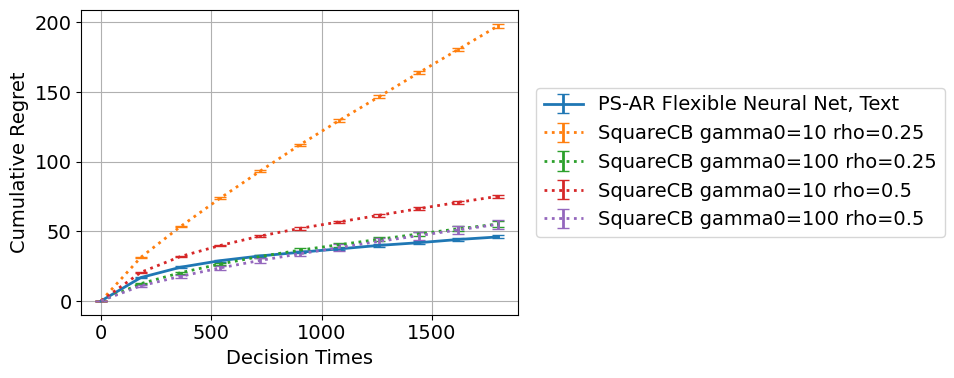

In [21]:
from collections import OrderedDict
names = OrderedDict([             
    ('PS-AR Flexible Neural Net, Text','BERT joint im=500'),
    ('SquareCB gamma0=10 rho=0.25', 'BERT squarecb 10.0 0.25'),
    ('SquareCB gamma0=100 rho=0.25', 'BERT squarecb 100.0 0.25'),
    ('SquareCB gamma0=10 rho=0.5', 'BERT squarecb 10.0 0.5'),
    ('SquareCB gamma0=100 rho=0.5', 'BERT squarecb 100.0 0.5'),
])
from util import make_plots_good
make_plots_good()
skip_val = 180

linestyle = ['-', ':', ':', ':', ':', ':', ':', ':', ':', ':', ':', ':']

plt.set_loglevel(level = 'warning')

fig, ax = plt.subplots(figsize=(5.5,4))
for k, (disp_name, key) in enumerate(names.items()):
    rewards_array = bandit_run_results[key]
    regret_array = bandit_run_results['oracle'] - rewards_array

    cum_regret_array = np.cumsum(regret_array, axis=1)
    cum_regret = np.mean(cum_regret_array, axis=0)
    cum_regret_stderr = np.std(cum_regret_array, axis=0)  / np.sqrt(num_bandit_envs)

    cutoff_num = 11
    ax.errorbar(x=np.arange(0,T+1)[::skip_val][:cutoff_num], y=cum_regret[::skip_val][:cutoff_num], 
                yerr=cum_regret_stderr[::skip_val][:cutoff_num], 
                capsize=4, linewidth=2, label=disp_name, 
                linestyle=linestyle[k])
    ax.grid(True)
ax.set_ylabel("Cumulative Regret")
ax.set_xlabel("Decision Times")
plt.tight_layout()
label_params = ax.get_legend_handles_labels() 
ax.legend(*label_params, loc="center right", bbox_to_anchor=(2, 0.5))

# Experiment section plot

### legends 

In [22]:
import matplotlib.pyplot as plt
from collections import OrderedDict
import numpy as np

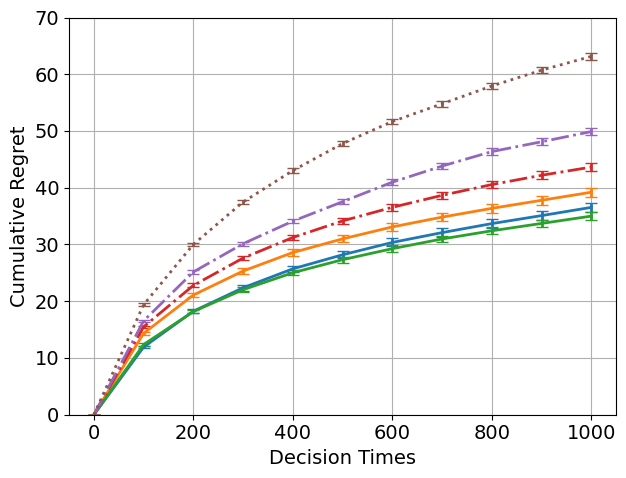

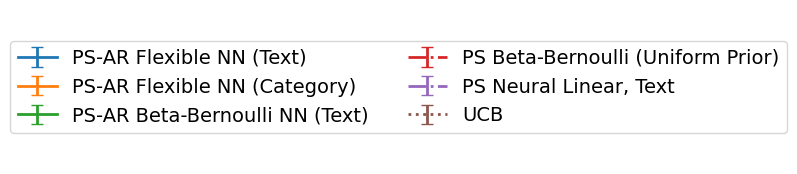

In [24]:
from collections import OrderedDict
names = OrderedDict([
    ('PS-AR Flexible NN (Text)','BERT joint im=500'),
    ('PS-AR Flexible NN (Category)','category joint im=500'),
    ('PS-AR Beta-Bernoulli NN (Text)','BERT bb joint ab im=500'),
    ('PS Beta-Bernoulli (Uniform Prior)','BB flat prior'),
    ('PS Neural Linear, Text', 'GG marginal 1 0.25'),
    ('UCB','UCB'),
])
from util import make_plots_good
make_plots_good()
skip_val = 100

linestyle = ['-', '-', '-', '-.','-.',':', ':', ':', '-.', '-.'] 

plt.set_loglevel(level = 'warning')
maxT=1000
fig, ax = plt.subplots(figsize=(6.5,5))
for k, (disp_name, key) in enumerate(names.items()):
    rewards_array = bandit_run_results[key][:,:maxT]
    regret_array = bandit_run_results['oracle'][:,:maxT] - rewards_array

    cum_regret_array = np.cumsum(regret_array, axis=1)
    cum_regret_array = np.hstack((np.zeros((len(cum_regret_array),1)), cum_regret_array))
    
    cum_regret = np.mean(cum_regret_array, axis=0)
    cum_regret_stderr = np.std(cum_regret_array, axis=0)  / np.sqrt(num_bandit_envs)

    cutoff_num = 11
    ax.errorbar(x=np.arange(0,T+1)[::skip_val][:cutoff_num], y=cum_regret[::skip_val][:cutoff_num], 
                yerr=cum_regret_stderr[::skip_val][:cutoff_num], 
                capsize=4, linewidth=2, label=disp_name, 
                linestyle=linestyle[k])
    ax.grid(True)
    k+=1
ax.set_ylabel("Cumulative Regret")
ax.set_xlabel("Decision Times")
ax.set_ylim([0,70])
plt.tight_layout()

label_params = ax.get_legend_handles_labels() 

figl, axl = plt.subplots(figsize=(6,2))
axl.axis(False)
axl.legend(*label_params, loc="center", bbox_to_anchor=(0.5, 0.5), ncol=2)

### Make legend

/tmp/8076250.1.debian.q/ipykernel_38872/4221144749.py:31: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()
/tmp/8076250.1.debian.q/ipykernel_38872/4221144749.py:31: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


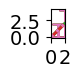

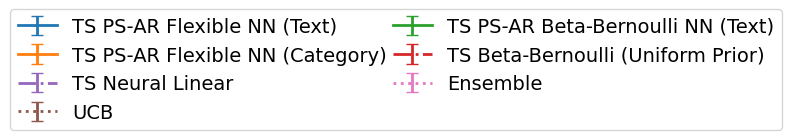

In [25]:
fig, ax = plt.subplots(figsize=(1,1))
names = OrderedDict([
    ('TS PS-AR Flexible NN (Text)','BERT joint im=500'),
    ('TS PS-AR Flexible NN (Category)','category joint im=500'),
    ('TS PS-AR Beta-Bernoulli NN (Text)','BERT bb joint ab im=500'),
    ('TS Beta-Bernoulli (Uniform Prior)','BB flat prior'),
    ('TS Neural Linear', 'GG marginal'),
    ('UCB','UCB'),   
    ('Ensemble','dpt'),
])

linestyle = ['-', '-', '-', '-.','-.',':', ':', ':', ':', ':']
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
colors = colors[:4]  + colors[4:6] + colors[6:7]
x = np.arange(3)

num_ordering = [0,1,4,5,2,3,6]

for i,name in enumerate(names.keys()):
    plt.errorbar(x,x,label=list(names.keys())[num_ordering[i]], capsize=4, linewidth=2, 
                 linestyle=linestyle[num_ordering[i]], yerr=x, color=colors[num_ordering[i]])

label_params3 = ax.get_legend_handles_labels() 
plt.tight_layout()

figl, axl = plt.subplots(figsize=(1.8,0.65))
axl.axis(False)
plt.tight_layout()
axl.legend(*label_params3, loc="center", bbox_to_anchor=(0.5, 0.5),ncols=2, columnspacing=0.3)#, prop={"size":50})
plt.tight_layout()